In [1]:
import sys
import os
import logging
import pandas as pd
import datasets
from pprint import pprint
KEY = '1-CGMLSM'
WORKSPACE_PATH = os.getcwd().split(KEY)[0]
print(WORKSPACE_PATH); os.chdir(WORKSPACE_PATH)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='[%(levelname)s:%(asctime)s:(%(filename)s@%(lineno)d %(name)s)]: %(message)s')

SPACE = {
    'DATA_RAW': f'_Data/0-Data_Raw',
    'DATA_RFT': f'_Data/1-Data_RFT',
    'DATA_CASE': f'_Data/2-Data_CASE',
    'DATA_CFDATA': f'_Data/3-Data_CFDATA',
    'DATA_SPLIT': f'_Data/4-Data_Split',
    'DATA_HFDATA': f'_Data/5-Data_HFData',
    'DATA_EXTERNAL': f'code/external',
    'CODE_FN': f'code/pipeline',
    'MODEL_ROOT': f'./_Model',
}
assert os.path.exists(SPACE['CODE_FN']), f'{SPACE["CODE_FN"]} not found'
print(SPACE['CODE_FN'])
sys.path.append(SPACE['CODE_FN'])

/home/jluo41/CGMLSM-Project/
code/pipeline


/home/jluo41/miniconda3/envs/nix/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nn.cgmlsm.configuration_cgmlsm import CgmLsmConfig
from nn.cgmlsm.modeling_cgmlsm import CgmLsmLMHeadModel

In [3]:
# HFDataName = 'CgmLsm_WellDoc_ds0p10'
# path = os.path.join(SPACE['DATA_HFDATA'], HFDataName)
# split_to_dataset = datasets.load_from_disk(path)
# remove_unused_columns = True # if using the processed dataset, set to True. 
# print(split_to_dataset)
# Name_to_Data = {i: {'ds_tfm': split_to_dataset[i]} for i in split_to_dataset}
# # exit()

In [4]:
import sys
import os
import logging
import pandas as pd
import datasets
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    RobertaConfig,
    RobertaForSequenceClassification,
    PreTrainedTokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from pprint import pprint
from transformers import (
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
# Calculate AUC (Area Under the ROC Curve)
# For multi-class, we use one-vs-rest approach
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [5]:
# ---------------------- CF Vocab Setup ----------------------
CF_to_CFvocab = {} # data_config['CF_to_CFvocab']

CFName = 'HM5MinStep'
interval_delta = pd.Timedelta(minutes=5)
idx2tkn = [pd.Timestamp('2022-01-01 00:00:00') + interval_delta * i for i in range(24 * 12)]
idx2tkn = [f'{i.hour:02d}:{i.minute:02d}' for i in idx2tkn]
tkn2idx = {tkn: idx for idx, tkn in enumerate(idx2tkn)}
CF_to_CFvocab[CFName] = {'idx2tkn': idx2tkn, 'tkn2idx': tkn2idx}

CFName = 'CGMValue'
idx2tkn = ["PAD"] + [str(i) for i in range(1, 400)] + ["UNKNOWN", "MASK"] + [f'Other_{i}' for i in range(0, 7)] 
tkn2idx = {tkn: idx for idx, tkn in enumerate(idx2tkn)}
CF_to_CFvocab[CFName] = {'idx2tkn': idx2tkn, 'tkn2idx': tkn2idx}

# ---------------------- Tokenizer Setup ----------------------
idx2tkn = CF_to_CFvocab['CGMValue']['idx2tkn']
vocab_dict = {token: idx for idx, token in enumerate(idx2tkn)}
wordlevel = WordLevel(vocab=vocab_dict, unk_token="UNKNOWN")
tokenizer_backend = Tokenizer(wordlevel)
tokenizer_backend.pre_tokenizer = Whitespace()
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer_backend,
    unk_token="UNKNOWN",
    pad_token="PAD",
    mask_token="MASK"
)

In [6]:
idx2tkn[100]

'100'

In [7]:
len(tokenizer)

409

In [8]:
hm_idx2tkn = CF_to_CFvocab['HM5MinStep']['idx2tkn']

model_path = '_Model/CGMOnlyLSM/checkpoint__epoch2.16802__fingerprint'
config = CgmLsmConfig(
    vocab_size=len(tokenizer),
)
model = CgmLsmLMHeadModel.from_pretrained(model_path)
model

CgmLsmLMHeadModel(
  (transformer): CgmLsmModel(
    (wte): Embedding(409, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x AttnBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=409, bias=False)
)

In [9]:

# Extract the embedding matrix (vocab_size x hidden_dim)
embedding_matrix = model.get_input_embeddings().weight.detach().cpu()

embedding_matrix

tensor([[-0.0187, -0.0382, -0.0269,  ...,  0.0266,  0.0026,  0.0289],
        [-0.1340,  0.0568, -0.0212,  ...,  0.0178, -0.0901,  0.0216],
        [-0.1318,  0.0098, -0.0028,  ..., -0.0408, -0.0430, -0.0031],
        ...,
        [-0.1018,  0.0173, -0.0062,  ..., -0.0139, -0.0567, -0.0022],
        [-0.1123,  0.0351, -0.0112,  ..., -0.0041, -0.0380,  0.0271],
        [-0.0844,  0.0531, -0.0119,  ..., -0.0141, -0.0418, -0.0156]])

In [10]:
embedding_matrix.shape

torch.Size([409, 768])

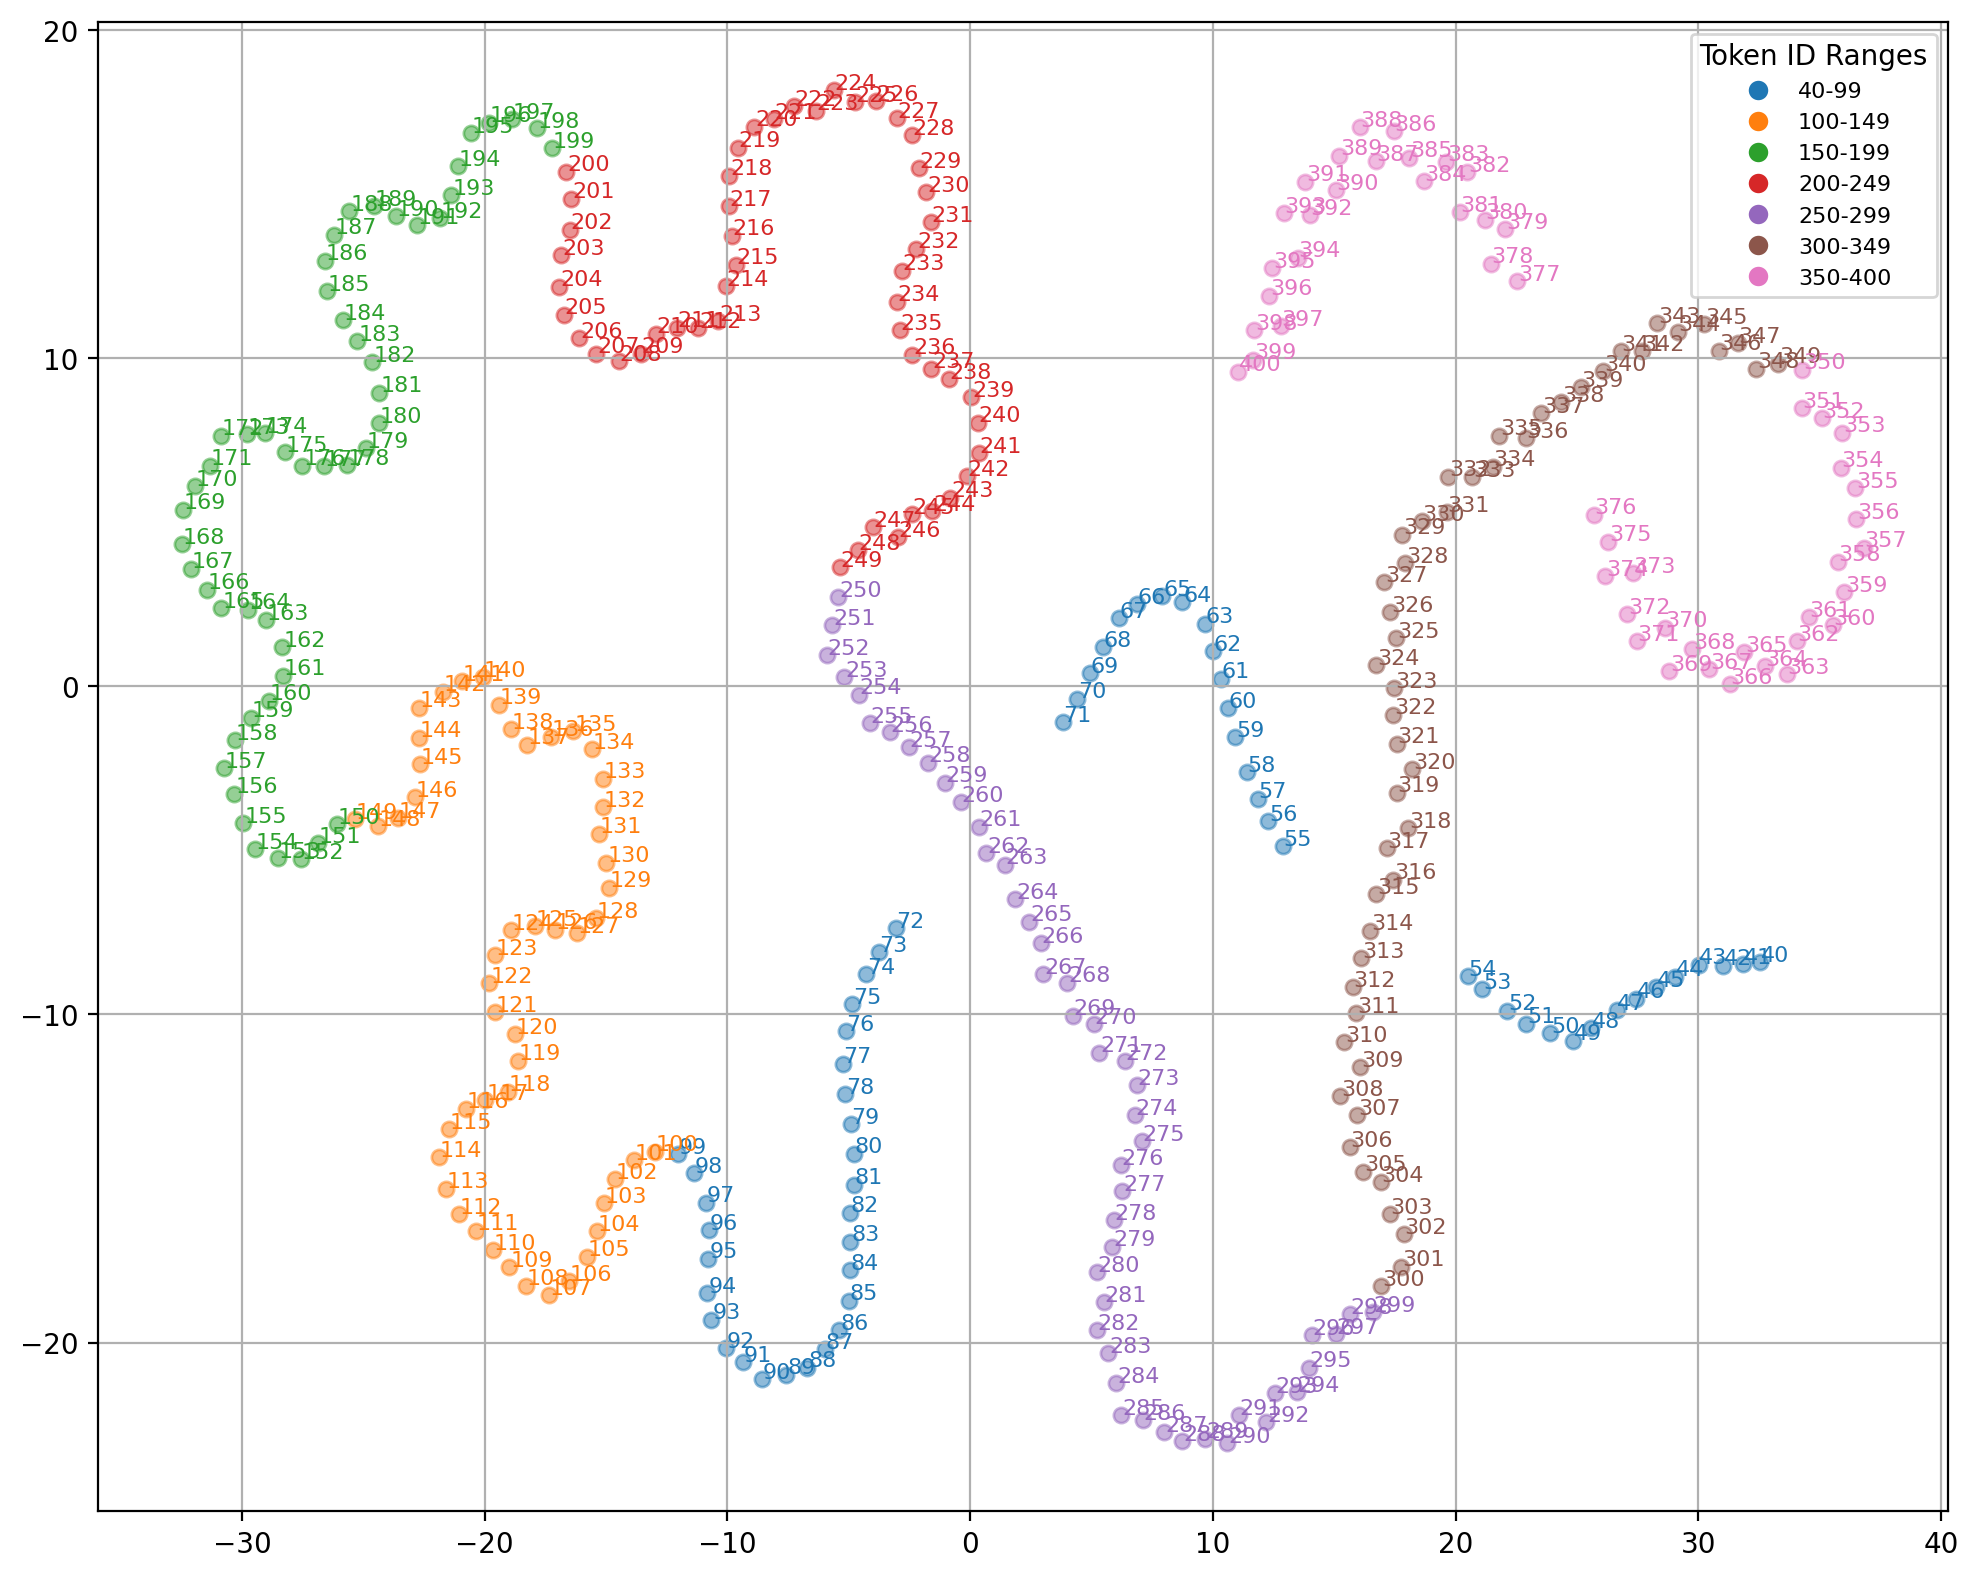

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Token ID range
token_ids = list(range(40, 401))  # inclusive
tokens = token_ids
embeddings = embedding_matrix[token_ids]

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Define color groups (6 bins)
def get_color_group(token_id):
    if 40 <= token_id < 100:
        return 0
    elif 100 <= token_id < 150:
        return 1
    elif 150 <= token_id < 200:
        return 2
    elif 200 <= token_id < 250:
        return 3
    elif 250 <= token_id < 300:
        return 4
    elif 300 <= token_id < 350:
        return 5
    elif 350 <= token_id <= 400:
        return 6
    else:
        raise ValueError(f"Token ID {token_id} out of range")

# Get color group for each token
color_groups = [get_color_group(tid) for tid in token_ids]
cmap = plt.get_cmap("tab10")  # or try 'tab20', 'Set1', etc.

# Plot
plt.figure(figsize=(10, 8), dpi=200)
for i, token in enumerate(tokens):
    x, y = embeddings_2d[i]
    color = cmap(color_groups[i])
    plt.scatter(x, y, color=color, alpha=0.5, s = 30)
    plt.text(x + 0.03, y + 0.03, str(token), fontsize=8, color=color)

# Add legend manually
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='40-99', markerfacecolor=cmap(0), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='100-149', markerfacecolor=cmap(1), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='150-199', markerfacecolor=cmap(2), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='200-249', markerfacecolor=cmap(3), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='250-299', markerfacecolor=cmap(4), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='300-349', markerfacecolor=cmap(5), markersize=8),
    Line2D([0], [0], marker='o', color='w', label='350-400', markerfacecolor=cmap(6), markersize=8),
]
plt.legend(handles=legend_elements, title="Token ID Ranges", fontsize=8)

# plt.title("CGM-LSM Token Embeddings (Colored by Glucose Range)", loc = 'left')
plt.grid(True)
plt.tight_layout()
plt.show()

